## Comprehensive Backtesting and Optimization of VWAP + Candlestick Pattern Strategies

This notebook implements a complete trading strategy analysis framework combining VWAP (Volume Weighted Average Price) with various candlestick patterns for systematic backtesting, optimization, and performance evaluation.

## 1. Environment Setup and Data Loading

In [69]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import talib as ta
import random
import warnings
from datetime import datetime
import time
from typing import List, Dict, Tuple, Optional
import concurrent.futures
from pathlib import Path

# Backtesting libraries
from backtesting import Strategy, Backtest
from backtesting.lib import crossover

# from backtesting.test import random_ohlc_data

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
from IPython.display import display, HTML

# Optimization and statistics
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit

# Configure warnings and display settings
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# print("✅ All libraries imported successfully")
# print(f"📊 Pandas version: {pd.__version__}")
# print(f"🔢 NumPy version: {np.__version__}")
# print(f"📈 TA-Lib available: {hasattr(ta, 'CDLHAMMER')}")

In [70]:
# Load and validate data
def load_market_data(file_path: str) -> pd.DataFrame:
    """
    Load market data from CSV with proper error handling
    """
    try:
        # Load the CSV with MultiIndex columns (Tickers, OHLCV)
        df = pd.read_csv(file_path, header=[0,1], index_col=0)
        
        # Drop any rows that are completely NaN
        df = df.dropna(how='all')
        
        # Convert all values to float
        df = df.astype(float)
        
        # Convert index to datetime
        df.index = pd.to_datetime(df.index)

        print(f"Data loaded successfully: {df.shape}")
        print(f"Date range: {df.index.min()} to {df.index.max()}")
        print(f"Tickers: {list(df.columns.levels[0])}")

        return df
        
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        raise
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

# Load the data
data_path = "../00_data/data_AAPL_MSFT_GOOGL_AMZN_TSLA_META_NVDA_2020-01-01_2025-10-26_raw.csv"
df_raw = load_market_data(data_path)

# Display data info
print("\nData Overview:")
df_raw.head()

Data loaded successfully: (1462, 35)
Date range: 2020-01-02 00:00:00 to 2025-10-24 00:00:00
Tickers: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']

Data Overview:


Ticker            MSFT                                                  \
Price             Open        High         Low       Close      Volume   
Date                                                                     
2020-01-02  151.040856  152.895807  150.612792  152.791168  22622100.0   
2020-01-03  150.603275  152.153817  150.355939  150.888641  21116200.0   
2020-01-06  149.423644  151.345190  148.881420  151.278595  20813700.0   
2020-01-07  151.554487  151.887418  149.651970  149.899292  21634100.0   
2020-01-08  151.183463  152.962326  150.251234  152.286926  27746500.0   

Ticker           AMZN                                                   NVDA  \
Price            Open       High        Low      Close      Volume      Open   
Date                                                                           
2020-01-02  93.750000  94.900497  93.207497  94.900497  80580000.0  5.942537   
2020-01-03  93.224998  94.309998  93.224998  93.748497  75288000.0  5.851688   
2020-01-06  93.000000  95.184502  93.000000  95.143997  81236000.0  5.782494   
2020-01-07  95.224998  95.694504  94.601997  95.343002  80898000.0  5.928847   
2020-01-08  94.902000  95.550003  94.321999  94.598503  70160000.0  5.967677   

Ticker                                                     GOOGL             \
Price           High       Low     Close       Volume       Open       High   
Date                                                                          
2020-01-02  5.971409  5.892010  5.971409  237536000.0  66.958679  67.965233   
2020-01-03  5.919638  5.826797  5.875831  205384000.0  66.938316  68.216995   
2020-01-06  5.905700  5.756359  5.900473  262636000.0  67.118569  69.437081   
2020-01-07  6.017705  5.883796  5.971907  314856000.0  69.543357  69.694316   
2020-01-08  6.024426  5.927603  5.983109  277108000.0  69.263289  70.108958   

Ticker                                             TSLA                        \
Price             Low      Close      Volume       Open       High        Low   
Date                                                                            
2020-01-02  66.863336  67.965233  27278000.0  28.299999  28.713333  28.114000   
2020-01-03  66.904545  67.609680  23408000.0  29.366667  30.266666  29.128000   
2020-01-06  67.087291  69.411758  46768000.0  29.364668  30.104000  29.333332   
2020-01-07  69.101405  69.277687  34330000.0  30.760000  31.441999  30.224001   
2020-01-08  69.154542  69.770790  35314000.0  31.580000  33.232666  31.215334   

Ticker                                    META                          \
Price           Close       Volume        Open        High         Low   
Date                                                                     
2020-01-02  28.684000  142981500.0  205.483256  208.504623  205.006201   
2020-01-03  29.534000  266677500.0  205.940433  209.110876  205.682017   
2020-01-06  30.102667  151995000.0  205.433564  211.476314  205.254674   
2020-01-07  31.270666  268231500.0  211.516088  213.265300  210.452637   
2020-01-08  32.809334  467164500.0  211.694968  214.915122  211.307358   

Ticker                                   AAPL                        \
Price            Close      Volume       Open       High        Low   
Date                                                                  
2020-01-02  208.494690  12077100.0  71.545890  72.598892  71.292304   
2020-01-03  207.391479  11188400.0  71.765667  72.594055  71.608685   
2020-01-06  211.297424  17058900.0  70.954203  72.444336  70.703027   
2020-01-07  211.754608  14912400.0  72.415337  72.671341  71.845369   
2020-01-08  213.901367  13475000.0  71.768101  73.526318  71.768101   

Ticker                              
Price           Close       Volume  
Date                                
2020-01-02  72.538513  135480400.0  
2020-01-03  71.833290  146322800.0  
2020-01-06  72.405693  118387200.0  
2020-01-07  72.065147  108872000.0  
2020-01-08  73.224426  132079200.0

## 2. Data Preprocessing and Ticker Selection

In [71]:
def select_random_ticker(df: pd.DataFrame, seed: Optional[int] = None) -> Tuple[str, pd.DataFrame]:
    """
    Select a random ticker and return cleaned data
    """
    if seed:
        random.seed(seed)
        np.random.seed(seed)
    
    # Get available tickers
    tickers = list(df.columns.levels[0])
    selected_ticker = random.choice(tickers)
    
    print(f"Randomly selected ticker: {selected_ticker}")
    
    # Extract data for selected ticker
    ticker_data = df.xs(selected_ticker, level=0, axis=1)
    
    # Clean column names (lowercase)
    ticker_data.columns = [col.lower() for col in ticker_data.columns]
    
    # Remove any remaining NaN values
    ticker_data = ticker_data.dropna()
    
    print(f"Clean data shape: {ticker_data.shape}")
    print(f"Date range: {ticker_data.index.min()} to {ticker_data.index.max()}")
    
    return selected_ticker, ticker_data

# Select ticker and prepare data
# RANDOM_SEED = 42  # For reproducibility
# RANDOM_SEED should have also the possibility to randomly select an integer, 
# so that different runs can analyze different tickers
RANDOM_SEED = random.randint(1, 100)
ticker_name, df_clean = select_random_ticker(df_raw, seed=RANDOM_SEED)

# Display cleaned data
print(f"\nSample data for {ticker_name}:")
display(df_clean.head())
print(f"\nData statistics:")
display(df_clean.describe())

Randomly selected ticker: META
Clean data shape: (1462, 5)
Date range: 2020-01-02 00:00:00 to 2025-10-24 00:00:00

Sample data for META:


,open,high,low,close,volume
Date,,,,,
2020-01-02,205.483256,208.504623,205.006201,208.494690,12077100.0
2020-01-03,205.940433,209.110876,205.682017,207.391479,11188400.0
2020-01-06,205.433564,211.476314,205.254674,211.297424,17058900.0
2020-01-07,211.516088,213.265300,210.452637,211.754608,14912400.0
2020-01-08,211.694968,214.915122,211.307358,213.901367,13475000.0



Data statistics:


,open,high,low,close,volume
count,1462.000000,1462.000000,1462.000000,1462.000000,1.462000e+03
mean,351.904591,356.663457,347.144884,351.973173,2.191693e+07
std,176.167220,177.636495,174.049727,175.866905,1.508658e+07
min,89.528079,89.905748,87.550280,88.365250,4.726100e+06
25%,215.446836,219.101809,212.524846,216.388535,1.335718e+07
50%,302.559792,307.012377,298.455095,303.195892,1.848200e+07
75%,488.528438,494.904305,481.806455,487.775421,2.571165e+07
max,790.616435,795.712965,780.293380,789.467163,2.323166e+08


## 3. Indicator Calculation Functions

In [72]:
# Define all indicator calculation functions
def calculate_vwap(df: pd.DataFrame) -> pd.Series:
    """Calculate VWAP (Volume Weighted Average Price)"""
    try:
        typical_price = (df['high'] + df['low'] + df['close']) / 3
        vwap = (df['volume'] * typical_price).cumsum() / df['volume'].cumsum()
        return vwap
    except Exception as e:
        print(f"Error calculating VWAP: {e}")
        return pd.Series(index=df.index, dtype=float)

def calculate_atr(df: pd.DataFrame, period: int = 14) -> pd.Series:
    """Calculate ATR (Average True Range)"""
    try:
        high_low = df['high'] - df['low']
        high_close = (df['high'] - df['close'].shift()).abs()
        low_close = (df['low'] - df['close'].shift()).abs()
        true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
        atr = true_range.rolling(window=period).mean()
        return atr
    except Exception as e:
        print(f"Error calculating ATR: {e}")
        return pd.Series(index=df.index, dtype=float)

def calculate_candlestick_pattern(df: pd.DataFrame, pattern_name: str) -> pd.Series:
    """Calculate a specific candlestick pattern"""
    try:
        pattern_func = getattr(ta, pattern_name)
        result = pattern_func(df['open'], df['high'], df['low'], df['close'])
        return pd.Series(result, index=df.index)
    except Exception as e:
        print(f"Error calculating {pattern_name}: {e}")
        return pd.Series(index=df.index, dtype=float)

# Define all candlestick patterns
CANDLESTICK_PATTERNS = [
    # Bullish reversal patterns
    'CDLHAMMER', 'CDLINVERTEDHAMMER', 'CDLMORNINGSTAR', 'CDLMORNINGDOJISTAR',
    'CDLENGULFING', 'CDLPIERCING', 'CDLHARAMI', 'CDLHARAMICROSS', 'CDLTAKURI',
    
    # Bullish continuation patterns  
    'CDL3WHITESOLDIERS', 'CDLRISEFALL3METHODS', 'CDLMATHOLD', 
    'CDLSEPARATINGLINES', 'CDLTASUKIGAP',
    
    # Bullish bottom patterns
    'CDLABANDONEDBABY', 'CDLLADDERBOTTOM', 'CDLMATCHINGLOW', 'CDLUNIQUE3RIVER',
    
    # Bullish special patterns
    'CDL3INSIDE', 'CDL3OUTSIDE', 'CDLBELTHOLD', 'CDLBREAKAWAY',
    'CDLKICKING', 'CDLKICKINGBYLENGTH', 'CDLSTICKSANDWICH'
]

print(f"📊 Available candlestick patterns: {len(CANDLESTICK_PATTERNS)}")
for i, pattern in enumerate(CANDLESTICK_PATTERNS, 1):
    print(f"{i:2d}. {pattern}")

📊 Available candlestick patterns: 25
 1. CDLHAMMER
 2. CDLINVERTEDHAMMER
 3. CDLMORNINGSTAR
 4. CDLMORNINGDOJISTAR
 5. CDLENGULFING
 6. CDLPIERCING
 7. CDLHARAMI
 8. CDLHARAMICROSS
 9. CDLTAKURI
10. CDL3WHITESOLDIERS
11. CDLRISEFALL3METHODS
12. CDLMATHOLD
13. CDLSEPARATINGLINES
14. CDLTASUKIGAP
15. CDLABANDONEDBABY
16. CDLLADDERBOTTOM
17. CDLMATCHINGLOW
18. CDLUNIQUE3RIVER
19. CDL3INSIDE
20. CDL3OUTSIDE
21. CDLBELTHOLD
22. CDLBREAKAWAY
23. CDLKICKING
24. CDLKICKINGBYLENGTH
25. CDLSTICKSANDWICH


In [73]:
# # Test indicator calculations
# print("🧪 Testing indicator calculations...")

# # Calculate VWAP
# df_clean['vwap'] = calculate_vwap(df_clean)
# print(f"VWAP calculated - Valid values: {df_clean['vwap'].notna().sum()}/{len(df_clean)}")

# # Calculate ATR
# df_clean['atr'] = calculate_atr(df_clean, period=14)
# print(f"ATR calculated - Valid values: {df_clean['atr'].notna().sum()}/{len(df_clean)}")

# # Test a few candlestick patterns
# test_patterns = ['CDLHAMMER', 'CDLENGULFING', 'CDLMORNINGSTAR']
# for pattern in test_patterns:
#     df_clean[pattern.lower()] = calculate_candlestick_pattern(df_clean, pattern)
#     valid_signals = (df_clean[pattern.lower()] != 0).sum()
#     print(f"✅ {pattern} calculated - Signals found: {valid_signals}")

# # Display sample with indicators
# print(f"\nSample data with indicators:")
# display(df_clean[['open', 'high', 'low', 'close', 'volume', 'vwap', 'atr']].tail())

## 4. Strategy Configuration and Generation

In [74]:
def generate_strategy_configs(patterns: List[str]) -> List[Dict]:
    """
    Generate strategy configurations for all VWAP + candlestick combinations
    """
    strategies = []
    
    for pattern in patterns:
        strategy_config = {
            'name': f'VWAP_{pattern}',
            'primary_indicator': 'VWAP',
            'secondary_indicator': pattern,
            'description': f'VWAP combined with {pattern} candlestick pattern',
            'atr_period': 14,
            'sl_multiplier': 1.5,
            'tp_multiplier': 3.0,
            'pattern_function': pattern
        }
        strategies.append(strategy_config)
    
    return strategies

# Generate all strategy configurations
strategy_configs = generate_strategy_configs(CANDLESTICK_PATTERNS)

print(f"Generated {len(strategy_configs)} strategy configurations:")
print("\nStrategy List:")
for i, config in enumerate(strategy_configs[:10], 1):  # Show first 10
    print(f"{i:2d}. {config['name']} - {config['description']}")

if len(strategy_configs) > 10:
    print(f"    ... and {len(strategy_configs) - 10} more strategies")

print(f"\nSample strategy configuration:")
display(pd.DataFrame([strategy_configs[0]]).T)

Generated 25 strategy configurations:

Strategy List:
 1. VWAP_CDLHAMMER - VWAP combined with CDLHAMMER candlestick pattern
 2. VWAP_CDLINVERTEDHAMMER - VWAP combined with CDLINVERTEDHAMMER candlestick pattern
 3. VWAP_CDLMORNINGSTAR - VWAP combined with CDLMORNINGSTAR candlestick pattern
 4. VWAP_CDLMORNINGDOJISTAR - VWAP combined with CDLMORNINGDOJISTAR candlestick pattern
 5. VWAP_CDLENGULFING - VWAP combined with CDLENGULFING candlestick pattern
 6. VWAP_CDLPIERCING - VWAP combined with CDLPIERCING candlestick pattern
 7. VWAP_CDLHARAMI - VWAP combined with CDLHARAMI candlestick pattern
 8. VWAP_CDLHARAMICROSS - VWAP combined with CDLHARAMICROSS candlestick pattern
 9. VWAP_CDLTAKURI - VWAP combined with CDLTAKURI candlestick pattern
10. VWAP_CDL3WHITESOLDIERS - VWAP combined with CDL3WHITESOLDIERS candlestick pattern
    ... and 15 more strategies

Sample strategy configuration:


,0
name,VWAP_CDLHAMMER
primary_indicator,VWAP
secondary_indicator,CDLHAMMER
description,VWAP combined with CDLHAMMER candlestick pattern
atr_period,14
sl_multiplier,1.5
tp_multiplier,3.0
pattern_function,CDLHAMMER


## 5. Time Series Data Splitting

In [75]:
def create_time_series_splits(df: pd.DataFrame, n_splits: int = 3) -> List[Tuple]:
    """
    Create time series cross-validation splits
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = []
    
    print(f"Creating {n_splits} time series splits...")
    
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        train_start = df.index[train_idx[0]]
        train_end = df.index[train_idx[-1]]
        test_start = df.index[test_idx[0]]
        test_end = df.index[test_idx[-1]]
        
        train_data = df.iloc[train_idx]
        test_data = df.iloc[test_idx]
        
        split_info = {
            'split_number': i + 1,
            'train_data': train_data,
            'test_data': test_data,
            'train_period': (train_start, train_end),
            'test_period': (test_start, test_end),
            'train_size': len(train_data),
            'test_size': len(test_data)
        }
        
        splits.append(split_info)
        
        print(f"Split {i+1}:")
        print(f"  📈 Train: {train_start.strftime('%Y-%m-%d')} to {train_end.strftime('%Y-%m-%d')} ({len(train_data)} days)")
        print(f"  🧪 Test:  {test_start.strftime('%Y-%m-%d')} to {test_end.strftime('%Y-%m-%d')} ({len(test_data)} days)")
    
    return splits

# Create time series splits
ts_splits = create_time_series_splits(df_clean, n_splits=3)

# Use the last split for main analysis (largest training set)
main_split = ts_splits[-1]
train_data = main_split['train_data']
test_data = main_split['test_data']

print(f"\nUsing split {main_split['split_number']} for main analysis:")
print(f"Training data: {len(train_data)} days")
print(f"Testing data: {len(test_data)} days")

Creating 3 time series splits...
Split 1:
  📈 Train: 2020-01-02 to 2021-06-16 (367 days)
  🧪 Test:  2021-06-17 to 2022-11-25 (365 days)
Split 2:
  📈 Train: 2020-01-02 to 2022-11-25 (732 days)
  🧪 Test:  2022-11-28 to 2024-05-10 (365 days)
Split 3:
  📈 Train: 2020-01-02 to 2024-05-10 (1097 days)
  🧪 Test:  2024-05-13 to 2025-10-24 (365 days)

Using split 3 for main analysis:
Training data: 1097 days
Testing data: 365 days


## 6. Dynamic Strategy Class Creation

In [76]:
def create_vwap_strategy_class(pattern_name: str, atr_period: int = 14, 
                              sl_multiplier: float = 1.5, tp_multiplier: float = 3.0):
    """
    Dynamically create a VWAP + Candlestick strategy class
    """
    
    class VWAPCandlestickStrategy(Strategy):
        def init(self):
            # Store parameters as instance attributes
            self.atr_period = atr_period
            self.sl_multiplier = sl_multiplier
            self.tp_multiplier = tp_multiplier
            self.pattern_name = pattern_name
            
            # Calculate VWAP
            typical_price = (self.data.High + self.data.Low + self.data.Close) / 3
            volume_price = typical_price * self.data.Volume
            self.vwap = self.I(lambda: volume_price.cumsum() / self.data.Volume.cumsum(), name='VWAP')
            
            # Calculate ATR
            self.atr = self.I(ta.ATR, self.data.High, self.data.Low, self.data.Close, 
                             self.atr_period, name='ATR')
            
            # Calculate candlestick pattern
            pattern_func = getattr(ta, self.pattern_name)
            self.pattern = self.I(pattern_func, self.data.Open, self.data.High, 
                                 self.data.Low, self.data.Close, name=self.pattern_name)
            
            # Track entry levels
            self.entry_price = None
            self.stop_loss_level = None
            self.take_profit_level = None
        
        def next(self):
            # Entry conditions: Price above VWAP AND bullish candlestick pattern
            if (not self.position and 
                self.data.Close[-1] > self.vwap[-1] and  # Price above VWAP
                self.pattern[-1] > 0):  # Bullish pattern detected
                
                # Enter long position
                self.buy()
                
                # Set stop loss and take profit levels
                self.entry_price = self.data.Close[-1]
                self.stop_loss_level = self.entry_price - (self.atr[-1] * self.sl_multiplier)
                self.take_profit_level = self.entry_price + (self.atr[-1] * self.tp_multiplier)
            
            # Exit conditions
            if self.position:
                # Stop Loss
                if self.data.Low[-1] <= self.stop_loss_level:
                    self.position.close()
                    self.entry_price = None
                # Take Profit  
                elif self.data.High[-1] >= self.take_profit_level:
                    self.position.close()
                    self.entry_price = None
    
    # Set class name dynamically and add attributes for debugging
    VWAPCandlestickStrategy.__name__ = f"VWAP{pattern_name}Strategy"
    VWAPCandlestickStrategy.atr_period = atr_period
    VWAPCandlestickStrategy.sl_multiplier = sl_multiplier
    VWAPCandlestickStrategy.tp_multiplier = tp_multiplier
    VWAPCandlestickStrategy.pattern_name = pattern_name
    
    return VWAPCandlestickStrategy

# Test strategy class creation using parameters from strategy_configs
print("🧪 Testing strategy class creation with config parameters...")
test_config = strategy_configs[0]  # Use first strategy config
TestStrategy = create_vwap_strategy_class(
    pattern_name=test_config['pattern_function'],
    atr_period=test_config['atr_period'],
    sl_multiplier=test_config['sl_multiplier'],
    tp_multiplier=test_config['tp_multiplier']
)
print(f"Created strategy class: {TestStrategy.__name__}")
print(f"Strategy pattern: {TestStrategy.pattern_name}")
print(f"Parameters: ATR={TestStrategy.atr_period}, SL={TestStrategy.sl_multiplier}, TP={TestStrategy.tp_multiplier}")

🧪 Testing strategy class creation with config parameters...
Created strategy class: VWAPCDLHAMMERStrategy
Strategy pattern: CDLHAMMER
Parameters: ATR=14, SL=1.5, TP=3.0


## 7. Batch Backtesting Execution

In [77]:
def run_single_backtest(strategy_config: Dict, data: pd.DataFrame, 
                       cash: float = 10000, commission: float = 0.002) -> Dict:
    """
    Run a single backtest for a strategy configuration
    """
    try:
        # Prepare data (backtesting library expects uppercase columns)
        df_backtest = data.copy()
        df_backtest.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        
        # Create strategy class
        StrategyClass = create_vwap_strategy_class(
            pattern_name=strategy_config['pattern_function'],
            atr_period=strategy_config['atr_period'],
            sl_multiplier=strategy_config['sl_multiplier'],
            tp_multiplier=strategy_config['tp_multiplier']
        )
        
        # Run backtest
        bt = Backtest(df_backtest, StrategyClass, cash=cash, commission=commission)
        results = bt.run()
        
        # Add strategy info to results
        result_dict = results.to_dict()
        result_dict['strategy_name'] = strategy_config['name']
        result_dict['pattern'] = strategy_config['pattern_function']
        result_dict['backtest_object'] = bt
        result_dict['success'] = True
        result_dict['error'] = None
        
        return result_dict
        
    except Exception as e:
        return {
            'strategy_name': strategy_config['name'],
            'pattern': strategy_config['pattern_function'],
            'success': False,
            'error': str(e),
            'Return [%]': 0,
            '# Trades': 0
        }

def run_batch_backtests(strategy_configs: List[Dict], data: pd.DataFrame, 
                       max_strategies: Optional[int] = None) -> pd.DataFrame:
    """
    Run backtests for multiple strategies
    """
    if max_strategies:
        configs_to_run = strategy_configs[:max_strategies]
        print(f"Running backtests for first {max_strategies} strategies...")
    else:
        configs_to_run = strategy_configs
        print(f"Running backtests for all {len(configs_to_run)} strategies...")
    
    results = []
    
    # Run backtests sequentially with progress tracking
    for i, config in enumerate(configs_to_run, 1):
        print(f"({i}/{len(configs_to_run)}) Testing {config['name']}...", end=" ")
        
        result = run_single_backtest(config, data)
        results.append(result)
        
        if result['success']:
            trades = result.get('# Trades', 0)
            returns = result.get('Return [%]', 0)
            print(f"{trades} trades, {returns:.2f}% return")
        else:
            print(f"Failed: {result['error']}")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Filter successful backtests
    successful_results = results_df[results_df['success'] == True].copy()
    
    print(f"\nBacktest Summary:")
    print(f"Successful: {len(successful_results)}/{len(results_df)}")
    print(f"Failed: {len(results_df) - len(successful_results)}")

    if len(successful_results) > 0:
        print(f"Best performing strategy: {successful_results.loc[successful_results['Return [%]'].idxmax(), 'strategy_name']}")
        print(f"Best return: {successful_results['Return [%]'].max():.2f}%")
    
    return successful_results

# Run backtests on training data (limit to first 10 strategies for demo)
print("Starting batch backtesting on training data...")
train_results = run_batch_backtests(strategy_configs, train_data, max_strategies=10)

# Display top performing strategies
if len(train_results) > 0:
    print(f"\nTop 5 Performing Strategies (Training Data):")
    
    # Check which columns are available in the results
    available_columns = train_results.columns.tolist()
    print(f"Available columns: {available_columns}")
    
    # Define desired columns and their alternatives
    desired_columns = {
        'strategy_name': 'strategy_name',
        'Return [%]': 'Return [%]',
        '# Trades': '# Trades', 
        'Win Rate [%]': ['Win Rate [%]', 'Win Rate', 'WinRate [%]'],
        'Sharpe Ratio': ['Sharpe Ratio', 'SharpeRatio'],
        'Max Drawdown [%]': ['Max Drawdown [%]', 'Max. Drawdown [%]', 'MaxDrawdown [%]', 'Max Drawdown']
    }
    
    # Find which columns actually exist
    columns_to_show = []
    for desired, alternatives in desired_columns.items():
        if isinstance(alternatives, str):
            alternatives = [alternatives]
        
        found = False
        for alt in alternatives:
            if alt in available_columns:
                columns_to_show.append(alt)
                found = True
                break
        
        if not found:
            print(f"⚠️ Column '{desired}' not found in results")
    
    # Display available columns
    if len(columns_to_show) > 0:
        top_strategies = train_results.nlargest(5, 'Return [%]')[columns_to_show]
        display(top_strategies)
    else:
        print("⚠️ No suitable columns found for display")
        # Show first few columns of top strategies as fallback
        basic_columns = ['strategy_name', 'Return [%]', '# Trades']
        available_basic = [col for col in basic_columns if col in available_columns]
        if available_basic:
            top_strategies = train_results.nlargest(5, 'Return [%]')[available_basic]
            display(top_strategies)
        else:
            # Last resort - show all columns for top 5
            display(train_results.nlargest(5, 'Return [%]').head())

Starting batch backtesting on training data...
Running backtests for first 10 strategies...
(1/10) Testing VWAP_CDLHAMMER... 11 trades, 3.18% return
(2/10) Testing VWAP_CDLINVERTEDHAMMER... 8 trades, 1.04% return
(3/10) Testing VWAP_CDLMORNINGSTAR... 3 trades, -0.21% return
(4/10) Testing VWAP_CDLMORNINGDOJISTAR... 1 trades, -4.03% return
(5/10) Testing VWAP_CDLENGULFING... 21 trades, -16.48% return
(6/10) Testing VWAP_CDLPIERCING... 4 trades, 11.27% return
(7/10) Testing VWAP_CDLHARAMI... 24 trades, -22.48% return
(8/10) Testing VWAP_CDLHARAMICROSS... 5 trades, 14.77% return
(9/10) Testing VWAP_CDLTAKURI... 9 trades, 9.73% return
(10/10) Testing VWAP_CDL3WHITESOLDIERS... 0 trades, 0.00% return

Backtest Summary:
Successful: 10/10
Failed: 0
Best performing strategy: VWAP_CDLHARAMICROSS
Best return: 14.77%

Top 5 Performing Strategies (Training Data):
Available columns: ['Start', 'End', 'Duration', 'Exposure Time [%]', 'Equity Final [$]', 'Equity Peak [$]', 'Commissions [$]', 'Return [%

,strategy_name,Return [%],# Trades,Win Rate [%],Sharpe Ratio,Max. Drawdown [%]
7,VWAP_CDLHARAMICROSS,14.770328,5,40.000000,0.287993,-12.233039
5,VWAP_CDLPIERCING,11.268393,4,50.000000,0.546790,-7.334142
8,VWAP_CDLTAKURI,9.734735,9,44.444444,0.189431,-10.151547
0,VWAP_CDLHAMMER,3.180942,11,45.454545,0.073663,-16.486963
1,VWAP_CDLINVERTEDHAMMER,1.035814,8,25.000000,0.024266,-21.080410


## 8. Out-of-Sample Testing

In [83]:
def run_out_of_sample_testing(top_results: pd.DataFrame, test_data: pd.DataFrame, 
                             top_n: int = 5) -> pd.DataFrame:
    """
    Run out-of-sample testing on top performing strategies
    """
    # Get top N strategies
    top_strategies = top_results.nlargest(top_n, 'Return [%]')

    print(f"Running out-of-sample testing on top {top_n} strategies...")

    oos_results = []
    
    for idx, strategy_row in top_strategies.iterrows():
        strategy_name = strategy_row['strategy_name']
        pattern = strategy_row['pattern']
        
        print(f"Testing {strategy_name} on out-of-sample data...", end=" ")
        
        # Find original strategy config
        original_config = next(
            (config for config in strategy_configs if config['name'] == strategy_name), 
            None
        )
        
        if original_config:
            # Run backtest on test data
            oos_result = run_single_backtest(original_config, test_data)
            
            if oos_result['success']:
                # Add in-sample performance for comparison
                oos_result['in_sample_return'] = strategy_row['Return [%]']
                oos_result['out_of_sample_return'] = oos_result['Return [%]']
                oos_result['performance_degradation'] = (
                    strategy_row['Return [%]'] - oos_result['Return [%]']
                )
                
                oos_results.append(oos_result)
                print(f"OOS Return: {oos_result['Return [%]']:.2f}% (IS: {strategy_row['Return [%]']:.2f}%)")
            else:
                print(f"Failed: {oos_result['error']}")
        else:
            print("Strategy config not found")

    return pd.DataFrame(oos_results)

# Run out-of-sample testing
if len(train_results) > 0:
    oos_results = run_out_of_sample_testing(train_results, test_data, top_n=5)
    
    if len(oos_results) > 0:
        print(f"\nOut-of-Sample Results:")
        oos_comparison = oos_results[[
            'strategy_name', 'in_sample_return', 'out_of_sample_return', 
            'performance_degradation', '# Trades', 'Win Rate [%]'
        ]].copy()
        
        display(oos_comparison)
        
        # Identify robust strategies (minimal performance degradation)
        robust_strategies = oos_comparison[oos_comparison['performance_degradation'] < 10]
        print(f"\nRobust strategies (< 10% performance degradation): {len(robust_strategies)}")
        if len(robust_strategies) > 0:
            display(robust_strategies)

Running out-of-sample testing on top 5 strategies...
Testing VWAP_CDLHARAMICROSS on out-of-sample data... OOS Return: -4.57% (IS: 14.77%)
Testing VWAP_CDLPIERCING on out-of-sample data... OOS Return: 0.00% (IS: 11.27%)
Testing VWAP_CDLTAKURI on out-of-sample data... OOS Return: 27.16% (IS: 9.73%)
Testing VWAP_CDLHAMMER on out-of-sample data... OOS Return: 5.62% (IS: 3.18%)
Testing VWAP_CDLINVERTEDHAMMER on out-of-sample data... OOS Return: 2.12% (IS: 1.04%)

Out-of-Sample Results:


,strategy_name,in_sample_return,out_of_sample_return,performance_degradation,# Trades,Win Rate [%]
0,VWAP_CDLHARAMICROSS,14.770328,-4.566428,19.336756,5,40.000000
1,VWAP_CDLPIERCING,11.268393,0.000000,11.268393,0,NaN
2,VWAP_CDLTAKURI,9.734735,27.160145,-17.425410,3,100.000000
3,VWAP_CDLHAMMER,3.180942,5.617998,-2.437056,6,33.333333
4,VWAP_CDLINVERTEDHAMMER,1.035814,2.117761,-1.081947,4,50.000000



Robust strategies (< 10% performance degradation): 3


,strategy_name,in_sample_return,out_of_sample_return,performance_degradation,# Trades,Win Rate [%]
2,VWAP_CDLTAKURI,9.734735,27.160145,-17.425410,3,100.000000
3,VWAP_CDLHAMMER,3.180942,5.617998,-2.437056,6,33.333333
4,VWAP_CDLINVERTEDHAMMER,1.035814,2.117761,-1.081947,4,50.000000


## 9. Parameter Optimization

In [79]:
def optimize_strategy_parameters(strategy_config: Dict, data: pd.DataFrame, 
                               optimize_params: Dict) -> Dict:
    """
    Optimize strategy parameters using grid search
    """
    print(f"⚙️ optimizing parameters for {strategy_config['name']}...")
    
    try:
        # Prepare data
        df_backtest = data.copy()
        df_backtest.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        
        # Create base strategy class
        BaseStrategyClass = create_vwap_strategy_class(
            pattern_name=strategy_config['pattern_function']
        )
        
        # Create optimizable strategy class
        class OptimizableStrategy(BaseStrategyClass):
            # Make parameters optimizable
            atr_period = optimize_params.get('atr_period', [14])
            sl_multiplier = optimize_params.get('sl_multiplier', [1.5])
            tp_multiplier = optimize_params.get('tp_multiplier', [3.0])
        
        # Run optimization
        bt = Backtest(df_backtest, OptimizableStrategy, cash=10000, commission=0.002)
        
        optimization_result = bt.optimize(
            atr_period=optimize_params.get('atr_period', [14]),
            sl_multiplier=optimize_params.get('sl_multiplier', [1.5]), 
            tp_multiplier=optimize_params.get('tp_multiplier', [3.0]),
            maximize='Sharpe Ratio',
            max_tries=50
        )
        
        return {
            'strategy_name': strategy_config['name'],
            'optimization_success': True,
            'optimized_params': {
                'atr_period': optimization_result._strategy.atr_period,
                'sl_multiplier': optimization_result._strategy.sl_multiplier,
                'tp_multiplier': optimization_result._strategy.tp_multiplier
            },
            'optimized_results': optimization_result.to_dict(),
            'backtest_object': bt
        }
        
    except Exception as e:
        print(f"❌ Optimization failed: {str(e)}")
        return {
            'strategy_name': strategy_config['name'],
            'optimization_success': False,
            'error': str(e)
        }

# Define parameter ranges for optimization
optimization_params = {
    'atr_period': [10, 14, 20],
    'sl_multiplier': [1.0, 1.5, 2.0],
    'tp_multiplier': [2.0, 3.0, 4.0]
}

# Optimize top 3 strategies
if len(train_results) >= 3:
    top_3_strategies = train_results.nlargest(3, 'Return [%]')
    
    print(f"⚙️ Optimizing parameters for top 3 strategies...")
    optimized_results = []
    
    for idx, strategy_row in top_3_strategies.iterrows():
        strategy_name = strategy_row['strategy_name']
        
        # Find original config
        original_config = next(
            (config for config in strategy_configs if config['name'] == strategy_name),
            None
        )
        
        if original_config:
            opt_result = optimize_strategy_parameters(
                original_config, train_data, optimization_params
            )
            optimized_results.append(opt_result)
    
    # Display optimization results
    successful_optimizations = [r for r in optimized_results if r.get('optimization_success', False)]
    
    if successful_optimizations:
        print(f"\n🎯 Optimization Results:")
        for result in successful_optimizations:
            print(f"\n📊 {result['strategy_name']}:")
            print(f"   Parameters: {result['optimized_params']}")
            opt_return = result['optimized_results'].get('Return [%]', 0)
            opt_sharpe = result['optimized_results'].get('Sharpe Ratio', 0)
            print(f"   Performance: {opt_return:.2f}% return, {opt_sharpe:.2f} Sharpe")
else:
    print("⚠️ Not enough successful strategies for optimization")

⚙️ Optimizing parameters for top 3 strategies...
⚙️ optimizing parameters for VWAP_CDLHARAMICROSS...
⚙️ optimizing parameters for VWAP_CDLPIERCING...
⚙️ optimizing parameters for VWAP_CDLTAKURI...

🎯 Optimization Results:

📊 VWAP_CDLHARAMICROSS:
   Parameters: {'atr_period': 14, 'sl_multiplier': 1.5, 'tp_multiplier': 3.0}
   Performance: 14.77% return, 0.29 Sharpe

📊 VWAP_CDLPIERCING:
   Parameters: {'atr_period': 14, 'sl_multiplier': 1.5, 'tp_multiplier': 3.0}
   Performance: 11.27% return, 0.55 Sharpe

📊 VWAP_CDLTAKURI:
   Parameters: {'atr_period': 14, 'sl_multiplier': 1.5, 'tp_multiplier': 3.0}
   Performance: 9.73% return, 0.19 Sharpe


## 10. Performance Visualization and Plotting

📊 Creating comprehensive performance plots...


KeyError: 'Max Drawdown [%]'

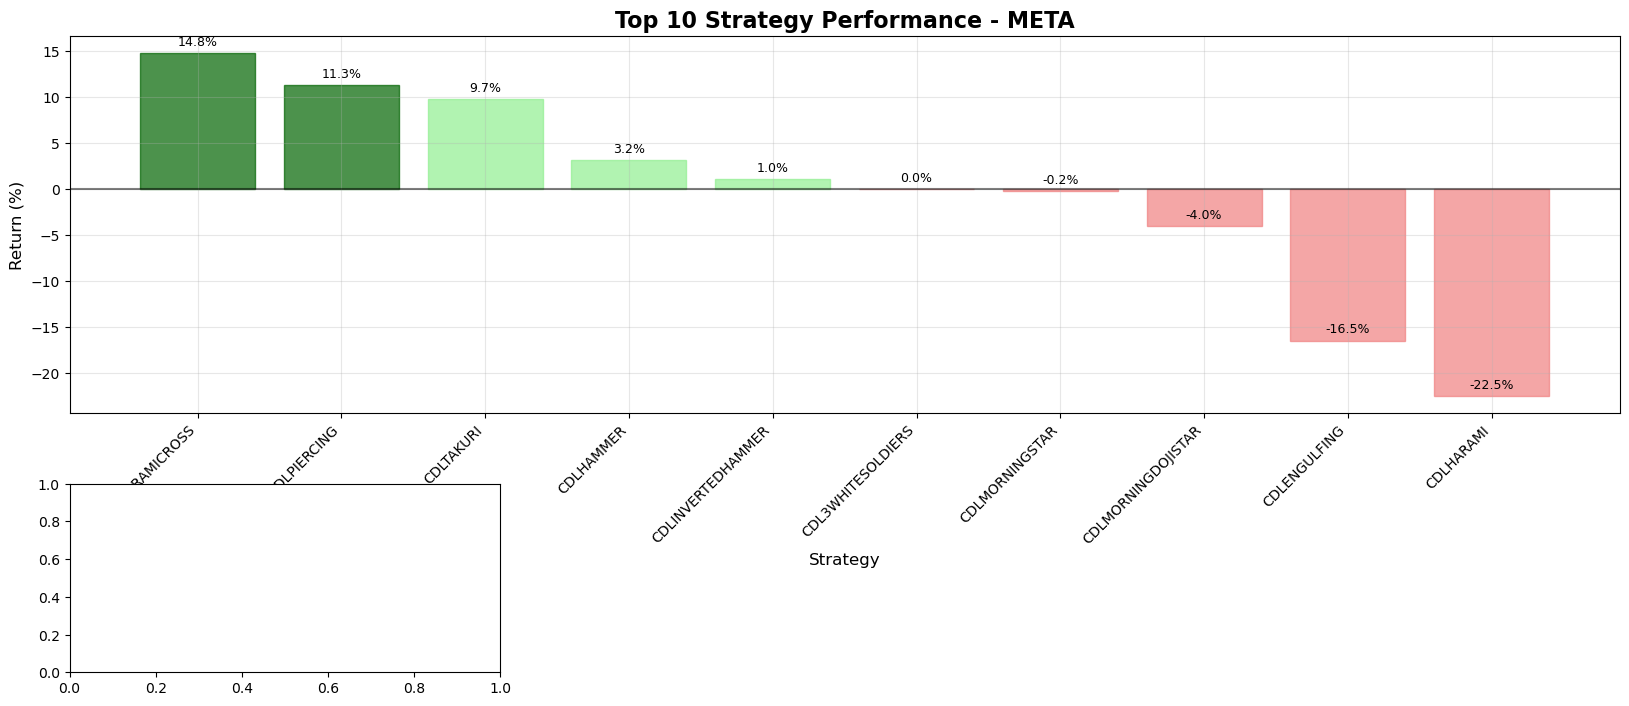

In [80]:
def create_comprehensive_plots(results_df: pd.DataFrame, data: pd.DataFrame, 
                              ticker_name: str) -> None:
    """
    Create comprehensive performance visualization plots
    """
    if len(results_df) == 0:
        print("⚠️ No results to plot")
        return
    
    # Set up the plotting environment
    plt.rcParams['figure.figsize'] = (15, 10)
    plt.rcParams['font.size'] = 10
    
    # Create main figure with subplots
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(4, 3, height_ratios=[2, 1, 1, 1], hspace=0.3, wspace=0.3)
    
    # 1. Strategy Performance Comparison
    ax1 = fig.add_subplot(gs[0, :])
    
    # Get top 10 strategies for plotting
    top_strategies = results_df.nlargest(10, 'Return [%]')
    
    # Create bar plot of returns
    bars = ax1.bar(range(len(top_strategies)), top_strategies['Return [%]'], 
                   color='steelblue', alpha=0.7)
    
    # Color bars based on performance
    for i, bar in enumerate(bars):
        returns = top_strategies.iloc[i]['Return [%]']
        if returns > 10:
            bar.set_color('darkgreen')
        elif returns > 0:
            bar.set_color('lightgreen')
        else:
            bar.set_color('lightcoral')
    
    ax1.set_title(f'Top 10 Strategy Performance - {ticker_name}', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Return (%)', fontsize=12)
    ax1.set_xlabel('Strategy', fontsize=12)
    ax1.set_xticks(range(len(top_strategies)))
    ax1.set_xticklabels([name.replace('VWAP_', '') for name in top_strategies['strategy_name']], 
                       rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 2. Risk-Return Scatter Plot
    ax2 = fig.add_subplot(gs[1, 0])
    
    # Filter out invalid values for scatter plot
    valid_data = results_df[
        (results_df['Return [%]'].notna()) & 
        (results_df['Max Drawdown [%]'].notna()) &
        (results_df['Max Drawdown [%]'] != 0)
    ].copy()
    
    if len(valid_data) > 0:
        scatter = ax2.scatter(valid_data['Max Drawdown [%]'].abs(), 
                            valid_data['Return [%]'],
                            c=valid_data['# Trades'], 
                            cmap='viridis', alpha=0.6, s=60)
        
        ax2.set_xlabel('Max Drawdown (%)', fontsize=10)
        ax2.set_ylabel('Return (%)', fontsize=10)
        ax2.set_title('Risk vs Return', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax2)
        cbar.set_label('Number of Trades', fontsize=9)
    
    # 3. Win Rate Distribution
    ax3 = fig.add_subplot(gs[1, 1])
    
    win_rates = results_df['Win Rate [%]'].dropna()
    if len(win_rates) > 0:
        ax3.hist(win_rates, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
        ax3.axvline(win_rates.mean(), color='red', linestyle='--', 
                   label=f'Mean: {win_rates.mean():.1f}%')
        ax3.set_xlabel('Win Rate (%)', fontsize=10)
        ax3.set_ylabel('Frequency', fontsize=10)
        ax3.set_title('Win Rate Distribution', fontsize=12, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # 4. Sharpe Ratio vs Return
    ax4 = fig.add_subplot(gs[1, 2])
    
    sharpe_data = results_df[
        (results_df['Sharpe Ratio'].notna()) & 
        (results_df['Return [%]'].notna())
    ].copy()
    
    if len(sharpe_data) > 0:
        ax4.scatter(sharpe_data['Sharpe Ratio'], sharpe_data['Return [%]'], 
                   alpha=0.6, color='orange', s=60)
        ax4.set_xlabel('Sharpe Ratio', fontsize=10)
        ax4.set_ylabel('Return (%)', fontsize=10)
        ax4.set_title('Sharpe Ratio vs Return', fontsize=12, fontweight='bold')
        ax4.grid(True, alpha=0.3)
        
        # Add trend line
        if len(sharpe_data) > 1:
            z = np.polyfit(sharpe_data['Sharpe Ratio'], sharpe_data['Return [%]'], 1)
            p = np.poly1d(z)
            ax4.plot(sharpe_data['Sharpe Ratio'].sort_values(), 
                    p(sharpe_data['Sharpe Ratio'].sort_values()), 
                    "r--", alpha=0.8, linewidth=1)
    
    # 5. Trade Count Analysis
    ax5 = fig.add_subplot(gs[2, 0])
    
    trade_counts = results_df['# Trades'].dropna()
    if len(trade_counts) > 0:
        ax5.bar(range(len(trade_counts)), sorted(trade_counts, reverse=True), 
               color='lightcoral', alpha=0.7)
        ax5.set_xlabel('Strategy Rank', fontsize=10)
        ax5.set_ylabel('Number of Trades', fontsize=10)
        ax5.set_title('Trade Count by Strategy', fontsize=12, fontweight='bold')
        ax5.grid(True, alpha=0.3)
    
    # 6. Performance Metrics Heatmap
    ax6 = fig.add_subplot(gs[2, 1:])
    
    # Select key metrics for heatmap
    heatmap_metrics = ['Return [%]', 'Sharpe Ratio', 'Win Rate [%]', '# Trades']
    heatmap_data = results_df[heatmap_metrics].head(10)
    
    if len(heatmap_data) > 0:
        # Normalize data for better visualization
        heatmap_normalized = heatmap_data.copy()
        for col in heatmap_metrics:
            if col in heatmap_normalized.columns:
                col_data = heatmap_normalized[col].fillna(0)
                if col_data.std() != 0:
                    heatmap_normalized[col] = (col_data - col_data.min()) / (col_data.max() - col_data.min())
        
        im = ax6.imshow(heatmap_normalized.T, cmap='RdYlGn', aspect='auto')
        
        # Set ticks and labels
        ax6.set_xticks(range(len(heatmap_data)))
        ax6.set_xticklabels([name.replace('VWAP_', '')[:10] + '...' if len(name) > 13 else name.replace('VWAP_', '') 
                           for name in heatmap_data.index], rotation=45, ha='right')
        ax6.set_yticks(range(len(heatmap_metrics)))
        ax6.set_yticklabels(heatmap_metrics)
        ax6.set_title('Performance Metrics Heatmap (Normalized)', fontsize=12, fontweight='bold')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax6)
        cbar.set_label('Normalized Value', fontsize=9)
    
    # 7. Price Chart with VWAP
    ax7 = fig.add_subplot(gs[3, :])
    
    # Plot price and VWAP for context
    recent_data = data.tail(500)  # Last 500 days
    ax7.plot(recent_data.index, recent_data['close'], label=f'{ticker_name} Price', 
            color='blue', linewidth=1, alpha=0.8)
    
    if 'vwap' in recent_data.columns:
        ax7.plot(recent_data.index, recent_data['vwap'], label='VWAP', 
                color='red', linewidth=1.5, alpha=0.8)
    
    ax7.set_title(f'{ticker_name} Price vs VWAP (Last 500 Days)', fontsize=12, fontweight='bold')
    ax7.set_ylabel('Price ($)', fontsize=10)
    ax7.set_xlabel('Date', fontsize=10)
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # Format x-axis dates
    ax7.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax7.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax7.xaxis.get_majorticklabels(), rotation=45)
    
    plt.suptitle(f'VWAP Strategy Analysis - {ticker_name}', fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    print("✅ Comprehensive plots created successfully!")

# Create plots for training results
if len(train_results) > 0:
    print("📊 Creating comprehensive performance plots...")
    create_comprehensive_plots(train_results, df_clean, ticker_name)
else:
    print("⚠️ No successful backtest results to plot")

In [ ]:
def plot_individual_strategy_performance(strategy_result: Dict, data: pd.DataFrame, 
                                       ticker_name: str) -> None:
    """
    Plot detailed performance for a single strategy
    """
    if not strategy_result.get('success', False):
        print("⚠️ Cannot plot failed strategy")
        return
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Get the backtest object to access detailed results
    bt = strategy_result.get('backtest_object')
    strategy_name = strategy_result.get('strategy_name', 'Unknown')
    
    # 1. Price chart with entry/exit points (if backtest object available)
    recent_data = data.tail(500)
    ax1.plot(recent_data.index, recent_data['close'], label=f'{ticker_name} Price', 
            color='blue', linewidth=1)
    
    if 'vwap' in recent_data.columns:
        ax1.plot(recent_data.index, recent_data['vwap'], label='VWAP', 
                color='red', linewidth=1.5, alpha=0.7)
    
    ax1.set_title(f'{strategy_name} - Price & VWAP', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Performance metrics bar chart
    metrics = {
        'Return (%)': strategy_result.get('Return [%]', 0),
        'Sharpe Ratio': strategy_result.get('Sharpe Ratio', 0),
        'Win Rate (%)': strategy_result.get('Win Rate [%]', 0),
        'Max DD (%)': -abs(strategy_result.get('Max Drawdown [%]', 0))
    }
    
    colors = ['green' if v > 0 else 'red' for v in metrics.values()]
    bars = ax2.bar(metrics.keys(), metrics.values(), color=colors, alpha=0.7)
    ax2.set_title('Key Performance Metrics', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars, metrics.values()):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height > 0 else -0.5),
                f'{value:.1f}', ha='center', va='bottom' if height > 0 else 'top')
    
    # 3. Trade statistics
    trade_stats = {
        'Total Trades': strategy_result.get('# Trades', 0),
        'Winning Trades': int(strategy_result.get('# Trades', 0) * strategy_result.get('Win Rate [%]', 0) / 100),
        'Avg Trade (%)': strategy_result.get('Avg Trade [%]', 0),
        'Best Trade (%)': strategy_result.get('Best Trade [%]', 0),
        'Worst Trade (%)': strategy_result.get('Worst Trade [%]', 0)
    }
    
    ax3.barh(list(trade_stats.keys()), list(trade_stats.values()), color='skyblue', alpha=0.7)
    ax3.set_title('Trade Statistics', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Value')
    ax3.grid(True, alpha=0.3)
    
    # 4. Risk metrics
    risk_metrics = {
        'Volatility (%)': strategy_result.get('Volatility (ann.) [%]', 0),
        'Max Drawdown (%)': abs(strategy_result.get('Max Drawdown [%]', 0)),
        'Calmar Ratio': strategy_result.get('Calmar Ratio', 0) if strategy_result.get('Calmar Ratio') not in ['N/A', None] else 0,
        'Sortino Ratio': strategy_result.get('Sortino Ratio', 0) if strategy_result.get('Sortino Ratio') not in ['N/A', None] else 0
    }
    
    ax4.pie([max(0.1, abs(v)) for v in risk_metrics.values()], 
           labels=risk_metrics.keys(), autopct='%1.1f%%', startangle=90)
    ax4.set_title('Risk Profile', fontsize=14, fontweight='bold')
    
    plt.suptitle(f'Detailed Analysis: {strategy_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Plot detailed analysis for best strategy
if len(train_results) > 0:
    best_strategy = train_results.loc[train_results['Return [%]'].idxmax()].to_dict()
    print(f"📊 Creating detailed analysis for best strategy: {best_strategy['strategy_name']}")
    plot_individual_strategy_performance(best_strategy, df_clean, ticker_name)

## 11. Monte Carlo Simulation and Robustness Testing

In [ ]:
def run_monte_carlo_simulation(strategy_config: Dict, original_data: pd.DataFrame, 
                              n_simulations: int = 100, random_seed: int = 42) -> Dict:
    """
    Run Monte Carlo simulation for strategy robustness testing
    """
    np.random.seed(random_seed)
    random.seed(random_seed)
    
    print(f"🎲 Running Monte Carlo simulation for {strategy_config['name']} ({n_simulations} runs)...")
    
    results = []
    
    # Generate random OHLC data based on original data statistics
    ohlc_generator = random_ohlc_data(original_data[['open', 'high', 'low', 'close', 'volume']])
    
    for i in range(n_simulations):
        try:
            # Generate random data
            random_data = next(ohlc_generator)
            random_data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
            
            # Run backtest on random data
            result = run_single_backtest(strategy_config, random_data)
            
            if result['success']:
                results.append({
                    'simulation': i + 1,
                    'return': result.get('Return [%]', 0),
                    'sharpe': result.get('Sharpe Ratio', 0),
                    'max_dd': result.get('Max Drawdown [%]', 0),
                    'trades': result.get('# Trades', 0),
                    'win_rate': result.get('Win Rate [%]', 0)
                })
            
            if (i + 1) % 20 == 0:
                print(f"  ⏳ Completed {i + 1}/{n_simulations} simulations...")
                
        except Exception as e:
            continue
    
    if len(results) == 0:
        return {'success': False, 'error': 'No successful simulations'}
    
    # Calculate statistics
    returns = [r['return'] for r in results]
    sharpes = [r['sharpe'] for r in results if not pd.isna(r['sharpe'])]
    
    mc_stats = {
        'success': True,
        'n_successful_sims': len(results),
        'return_stats': {
            'mean': np.mean(returns),
            'std': np.std(returns),
            'min': np.min(returns),
            'max': np.max(returns),
            'percentile_5': np.percentile(returns, 5),
            'percentile_95': np.percentile(returns, 95)
        },
        'sharpe_stats': {
            'mean': np.mean(sharpes) if sharpes else 0,
            'std': np.std(sharpes) if sharpes else 0,
        },
        'positive_return_probability': len([r for r in returns if r > 0]) / len(returns),
        'raw_results': results
    }
    
    print(f"✅ Monte Carlo completed: {len(results)} successful simulations")
    print(f"📊 Mean return: {mc_stats['return_stats']['mean']:.2f}% ± {mc_stats['return_stats']['std']:.2f}%")
    print(f"🎯 Positive return probability: {mc_stats['positive_return_probability']:.2%}")
    
    return mc_stats

def plot_monte_carlo_results(mc_results: Dict, strategy_name: str) -> None:
    """
    Plot Monte Carlo simulation results
    """
    if not mc_results.get('success', False):
        print("⚠️ No Monte Carlo results to plot")
        return
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    results = mc_results['raw_results']
    returns = [r['return'] for r in results]
    sharpes = [r['sharpe'] for r in results if not pd.isna(r['sharpe'])]
    
    # 1. Return distribution
    ax1.hist(returns, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(np.mean(returns), color='red', linestyle='--', 
               label=f'Mean: {np.mean(returns):.2f}%')
    ax1.axvline(0, color='black', linestyle='-', alpha=0.5)
    ax1.set_xlabel('Return (%)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Monte Carlo Return Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Cumulative return probability
    sorted_returns = np.sort(returns)
    cumprob = np.arange(1, len(sorted_returns) + 1) / len(sorted_returns)
    
    ax2.plot(sorted_returns, cumprob, color='green', linewidth=2)
    ax2.axvline(0, color='red', linestyle='--', alpha=0.7, label='Break-even')
    ax2.set_xlabel('Return (%)')
    ax2.set_ylabel('Cumulative Probability')
    ax2.set_title('Cumulative Return Probability')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Sharpe ratio distribution (if available)
    if sharpes:
        ax3.hist(sharpes, bins=20, alpha=0.7, color='orange', edgecolor='black')
        ax3.axvline(np.mean(sharpes), color='red', linestyle='--',
                   label=f'Mean: {np.mean(sharpes):.2f}')
        ax3.set_xlabel('Sharpe Ratio')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Sharpe Ratio Distribution')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'No Sharpe Ratio Data', ha='center', va='center', 
                transform=ax3.transAxes, fontsize=14)
        ax3.set_title('Sharpe Ratio Distribution')
    
    # 4. Risk-return scatter
    max_dds = [abs(r['max_dd']) for r in results]
    ax4.scatter(max_dds, returns, alpha=0.6, color='purple')
    ax4.set_xlabel('Max Drawdown (%)')
    ax4.set_ylabel('Return (%)')
    ax4.set_title('Risk vs Return')
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle(f'Monte Carlo Analysis: {strategy_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Run Monte Carlo simulation on best strategy
if len(train_results) > 0:
    best_strategy_name = train_results.loc[train_results['Return [%]'].idxmax(), 'strategy_name']
    best_config = next(
        (config for config in strategy_configs if config['name'] == best_strategy_name),
        None
    )
    
    if best_config:
        # Prepare data in correct format for Monte Carlo
        mc_data = df_clean[['open', 'high', 'low', 'close', 'volume']].copy()
        mc_data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        
        print(f"🎲 Starting Monte Carlo simulation for best strategy: {best_strategy_name}")
        mc_results = run_monte_carlo_simulation(best_config, mc_data, n_simulations=50)
        
        if mc_results.get('success', False):
            plot_monte_carlo_results(mc_results, best_strategy_name)
        else:
            print(f"❌ Monte Carlo simulation failed: {mc_results.get('error', 'Unknown error')}")
else:
    print("⚠️ No strategies available for Monte Carlo simulation")

## 12. Multi-Timeframe Analysis